# Current Analysis Notbook
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Artificial Data](#Artificial-Data)
4. [Analysis](#Analysis)
5. [Data Import](#Data-Import)
6. [Model Estimation](#Model-Estimation)

## Introduction
This notebook is used to analyse current data.

## Setup
In the following, code for the setup is executed.
This includes the import of all necessary libraries and the definition of all necessary functions.

In [1]:
import os

import sys
import logging
import numpy as np
import pandas as pd
import IPython.display as ipd

import librosa
import librosa.display

Determine if the code is executed in a notebook or not.

In [2]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
if isnotebook():
    sys.path.append(parentdir)
    sys.path.insert(0, parentdir)
else:
    sys.path.insert(0, currentdir)
    print(currentdir)

Logging is important!

In [3]:
logging.root.handlers = []
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

Import `anAIlysis` library.
This library is used to analyse diffetent types of data.
<br>
[**anAIlysis Documentation**](https://ai-gruppe.github.io/ai_internal_anAIlysis-rg_sw/)

In [4]:
from anAIlysis import ESA
from anAIlysis import signal_processing as DSP
# from anAIlysis import plotting as eplt
from anAIlysis import signal_analysis as SA
from anAIlysis import get_samplerate as GSR
from anAIlysis import file_handler as fh

# Set random seed
np.random.seed(seed=42)

There are several different backend for plotting in Matplotlib.
- `inline` is used for Jupyter Notebooks (Image in Notebook)
- `widget` is used for Jupyter Lab (Interactive Plot in Notebook)
- `WebAgg` is used for ssh connections without display (Interactive Plot in Browser)
- `TkAgg` is used for local plotting (Interactive Plot in Window)
- `Qt5Agg` is used for local plotting (Interactive Plot in Window)

In [5]:
# Use WebAgg if no display is connected (e.g. ssh) and not running as notebook
import matplotlib
if (os.name == 'posix' and "DISPLAY" not in os.environ) and not isnotebook():
    matplotlib.use('WebAgg')
elif isnotebook():
    try:
        get_ipython().run_line_magic('matplotlib', 'widget')
    except ModuleNotFoundError:
        get_ipython().run_line_magic('matplotlib', 'inline')

# Return used Matplotlib backend
logger.info(f"Matplotlib backend: {matplotlib.get_backend()}")

import matplotlib.pyplot as plt

INFO:__main__:Matplotlib backend: module://ipympl.backend_nbagg


## Artificial Data
### Create 3-Phase Current Sine Wave
Now, a three-phase sine wave is created.
It includes typical sine parameters like amplitude, frequency, theta and offset.
It also includes noise parameters like mean and standard deviation.
To generate a non-ideal sine wave, the noise is added to the sine wave as well as a random factor is added to some parameter.
$$y(t) = A \cdot sin(2 \cdot \pi \cdot f \cdot t + \theta) + o$$
$$ \theta = \frac{2 \cdot \pi}{3} \cdot n, n \in [0, 1, 2]$$

In [6]:
model = pd.DataFrame(columns=['amplitude', 'frequency', 'theta', 'offset', 'fs', 'length', 'time', 'signal', 'noise', 'signal_noise'])

for i in range(0, 3):
    model.at[i, 'amplitude'] = 1 + np.random.random_sample()
    model.at[i, 'frequency'] = 50
    model.at[i, 'theta'] = i * 2 * np.pi / 3.0 + np.random.random_sample()
    model.at[i, 'offset'] = 0 + np.random.random_sample()
    model.at[i, 'fs'] = 10e3
    model.at[i, 'length'] = 10 # in seconds
    model.at[i, 'time'] = np.arange(0, model.at[i, 'length'], 1 / model.at[i, 'fs'])
    model.at[i, 'signal'] = model.at[i, 'amplitude'] * np.sin(2 * np.pi * model.at[i, 'frequency'] * model.at[i, 'time'] + model.at[i, 'theta']) + model.at[i, 'offset']
    
    model.at[i, 'mu'] = 0
    model.at[i, 'sigma'] = 0.1
    model.at[i, 'noise'] = np.random.normal(model.at[i, 'mu'], model.at[i, 'sigma'], len(model.at[i, 'signal']))
    model.at[i, 'signal_noise'] = model.at[i, 'signal'] + model.at[i, 'noise']

### Plot Sine Wave
We now can plot the created sine waves with matplotlib.

Text(0, 0.5, 'Amplitude = sin(time)')

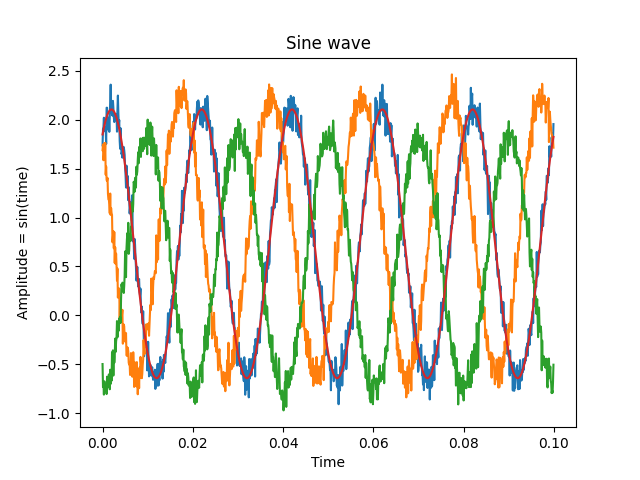

In [7]:
length_plot = int(0.1 * model.at[0, 'fs'])

fig, ax = plt.subplots()

# Sine with noise
for i in range(0, 3):
    ax.plot(model.at[i, 'time'][0:length_plot], model.at[i, 'signal_noise'][0:length_plot])

# Sine without noise
ax.plot(model.at[0, 'time'][0:length_plot], model.at[0, 'signal'][0:length_plot])
ax.set_title('Sine wave')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude = sin(time)')

## Analyse
In the following, we will cover the following topics:
- Fourier Transformation
- DQ-Transformation
- Motor Current Signature Analysis (MCSA)
- Enhanced Park's Vector Approach (EPVA)
- Instantaneous Power Signature Analysis (IPSA)
-

### Fourier Transformation

Text(0, 0.5, 'Amplitude')

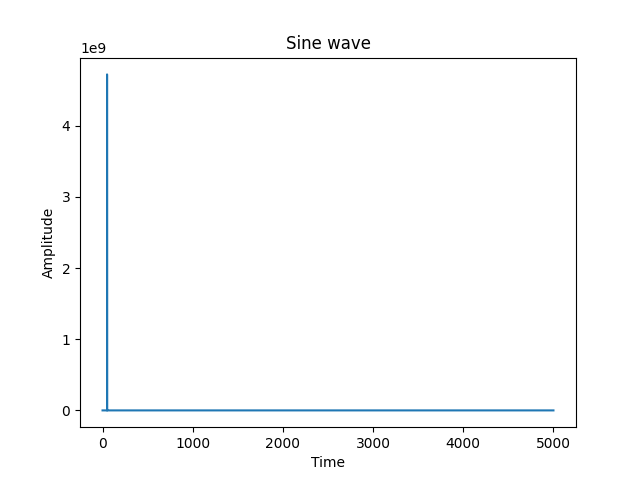

In [8]:
fig, ax = plt.subplots()

freq, fft = DSP.power_fft(model.at[0, 'signal_noise'], model.at[0, 'fs'])

ax.plot(freq, fft)
ax.set_title('Sine wave')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude [dB]')

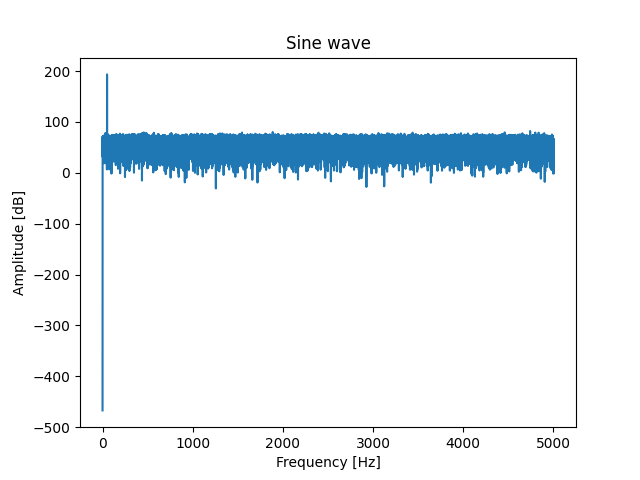

In [9]:
fig, ax = plt.subplots()

signal = model.at[0, 'signal_noise'] - np.mean(model.at[0, 'signal_noise'])

freq, fft = DSP.power_fft(signal, model.at[0, 'fs'])
fft = DSP.decibel(fft)

ax.plot(freq, fft)
ax.set_title('Sine wave')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')

### DQ-Transformation
The DQ-Transformation is used to transform a three-phase signal into a two-phase signal.
The transformation is based on the following matrix:
$$
\begin{align}
\begin{bmatrix}
I_{d} \\
I_{q} \\
\end{bmatrix}
&= \frac{2}{3}
\begin{bmatrix}
\cos(\theta) & \cos(\theta-\frac{2 \pi}{3}) & \cos(\theta-\frac{4 \pi}{3})\\
-\sin(\theta) & -\sin(\theta-\frac{2 \pi}{3}) & -\sin(\theta-\frac{4 \pi}{3})\\
\end{bmatrix}
\begin{bmatrix}
I_{U} \\
I_{V} \\
I_{W} \\
\end{bmatrix}
\end{align}
$$

#### DQ-Transformation without Noise

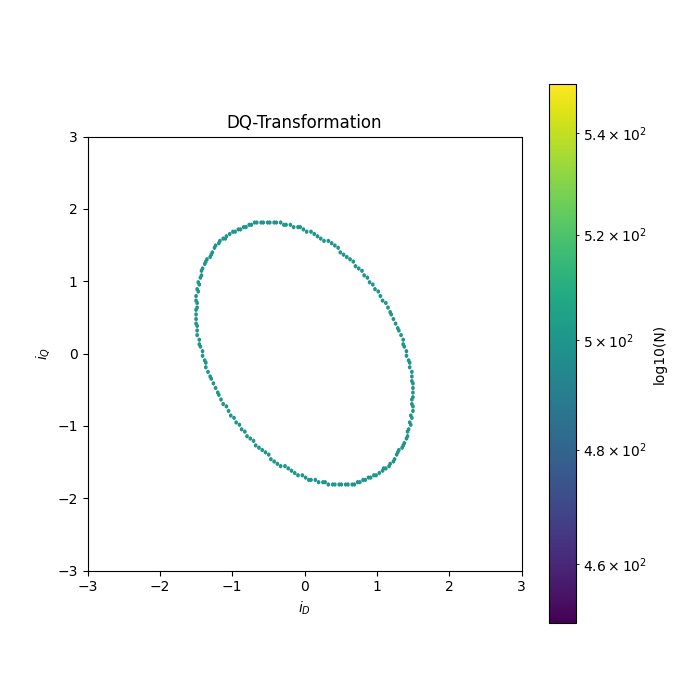

In [10]:
i_a = model.at[0, 'amplitude'] * np.sin(2 * np.pi * model.at[0, 'frequency'] * model.at[0, 'time'] + 0 * model.at[1, 'theta'])
i_b = model.at[0, 'amplitude'] * np.sin(2 * np.pi * model.at[0, 'frequency'] * model.at[0, 'time'] + 1 * model.at[1, 'theta'])
i_c = model.at[0, 'amplitude'] * np.sin(2 * np.pi * model.at[0, 'frequency'] * model.at[0, 'time'] + 2 * model.at[1, 'theta'])

i_d, i_q = ESA.dq(i_a, i_b, i_c)

lim = 3

fig, ax = plt.subplots(figsize=(7,7))
hb = ax.hexbin(i_d, i_q, bins='log')
# plt.legend(loc="upper left")
plt.xlabel(r'$i_D$')
plt.ylabel(r'$i_Q$')
ax.set(xlim=(-lim,lim), ylim=(-lim,lim))
ax.set_aspect('equal', 'box')
ax.set_title(f"DQ-Transformation")
cb = fig.colorbar(hb, ax=ax, label='log10(N)')

#### DQ-Transformation with Noise

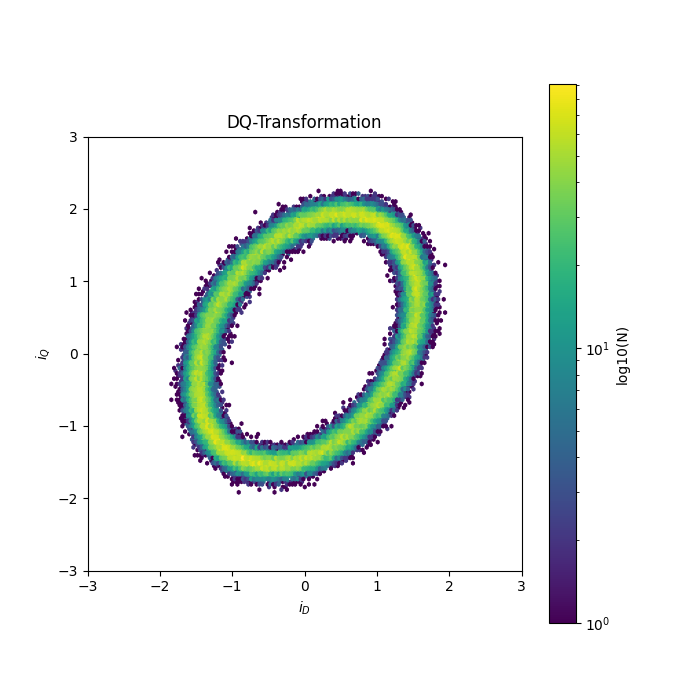

In [11]:
i_d, i_q = ESA.dq(model.at[0, 'signal_noise'], model.at[1, 'signal_noise'], model.at[2, 'signal_noise'])

lim = 3

fig, ax = plt.subplots(figsize=(7,7))
hb = ax.hexbin(i_d, i_q, bins='log')
# plt.legend(loc="upper left")
plt.xlabel(r'$i_D$')
plt.ylabel(r'$i_Q$')
ax.set(xlim=(-lim,lim), ylim=(-lim,lim))
ax.set_aspect('equal', 'box')
ax.set_title(f"DQ-Transformation")
cb = fig.colorbar(hb, ax=ax, label='log10(N)')

### Motor Current Signature Analysis (MCSA)
$$\mathrm{MCSA} = \mathit{FFT}(|i_n|^2)$$

Text(0.5, 1.0, 'Motor Current Signature Analysis')

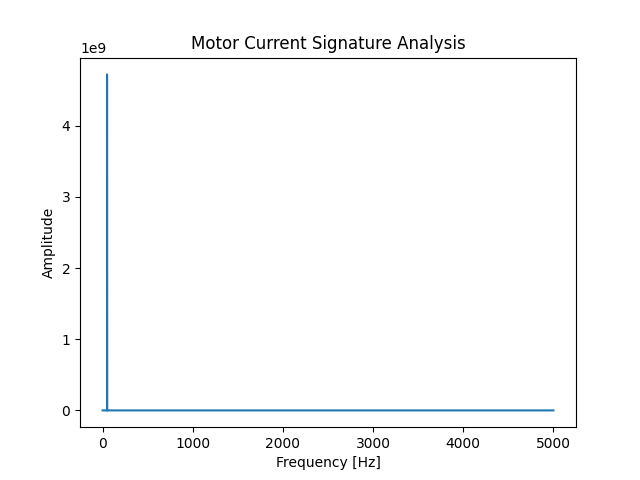

In [12]:
signal = model.at[0, 'signal_noise']
fs = model.at[0, 'fs']

freq, fft = ESA.csa(signal, fs=fs)

fig, ax = plt.subplots()
ax.plot(freq, fft)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Amplitude')
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
ax.set_title(f"Motor Current Signature Analysis")

## Enhanced Park's Vector Approach (EPVA)
$$\mathrm{EPVA} = \mathit{FFT}(|i_D + j i_Q|^2)$$

Text(0.5, 1.0, "Enhanced Park's Vector Approach")

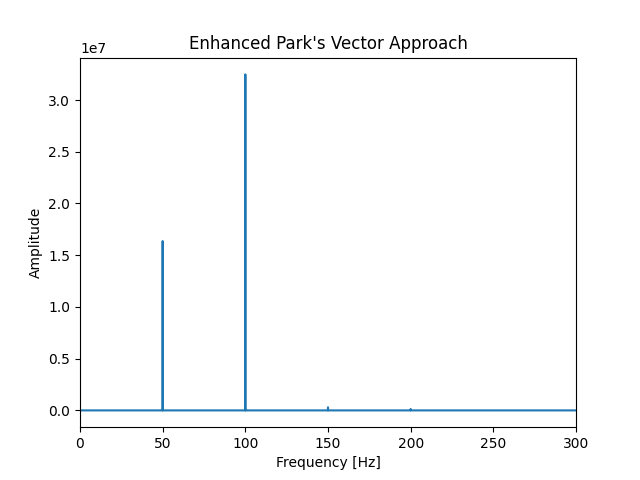

In [13]:
signal = model.at[0, 'signal_noise']
fs = model.at[0, 'fs']

freq, fft = ESA.epva(i_d, i_q, fs=fs)

fig, ax = plt.subplots()
ax.plot(freq, fft)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Amplitude')
ax.set_xlim((0, 3e2))
# ax.set_ylim(ylim)
ax.set_title(f"Enhanced Park's Vector Approach")

### Instantaneous Power Signature Analysis (IPSA)
$$p(t) = u(t) \cdot i(t)$$
$$\mathrm{IPSA} = \mathit{FFT}(p(t))$$

## Data Import
### PicoScope

In [14]:
import pandas as pd

data_path = 'data/SINUS.csv'

data_path = os.path.join(parentdir, data_path) if isnotebook() else data_path

data_df = pd.read_csv(data_path, index_col=0, header=[0, 1], sep=';', decimal=",")

Text(0, 0.5, 'Amplitude (V)')

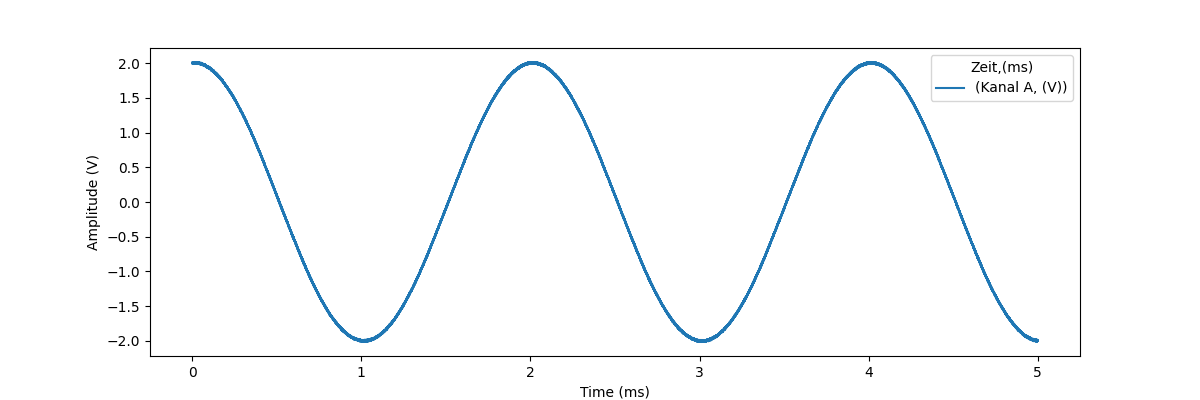

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
data_df.plot(ax=ax)
ax.set_xlabel('Time %s' % data_df.columns.names[1])
ax.set_ylabel('Amplitude %s' % data_df.columns[0][1])

In [16]:
channels = data_df.columns.get_level_values(0).unique()
amplitude = data_df[channels[0]].values

## Model Estimation
Estimate the parameters of the sine wave from given data.
<p>
<strong>Attention:</strong> The estimation is not perfect. Resonances in the system are not considered.

In [17]:
signals = [model.at[i, 'signal_noise'] for i in range(0, 3)]
fs = model.at[0, 'fs']

# Get model parameters
est_model = SA.calc_model(signals, fs)

# Create sine waves from model
est_signals = {}
for i in range(0, 3):
    est_signals[i] = SA.get_signal_from_model(est_model[i], fs, end_time=0.1)

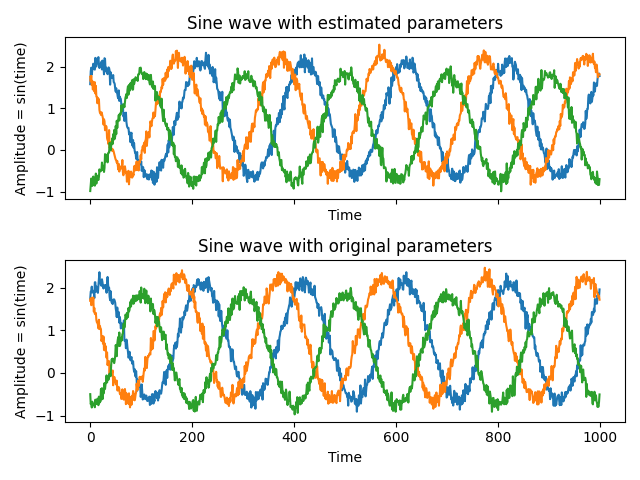

In [18]:
fig, axs = plt.subplots(nrows=2, sharex=True)

for i in range(0, 3):
    axs[0].plot(est_signals[i][0:1000])

# ax.plot(model.at[0, 'time'][0:length_plot], model.at[0, 'signal'][0:length_plot])
axs[0].set_title('Sine wave with estimated parameters')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude = sin(time)')

for i in range(0, 3):
    axs[1].plot(model.at[i, 'signal_noise'][0:1000])

# ax.plot(model.at[0, 'time'][0:length_plot], model.at[0, 'signal'][0:length_plot])
axs[1].set_title('Sine wave with original parameters')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude = sin(time)')

plt.tight_layout()

## Harmonic Analysis
Simulate a bearing fault and analyze the harmonic content of the signal.
For the example of a bearings with between six and twelve balls.
$$n_s = \frac{60 \cdot f}{p} \left[\frac{1}{\mathrm{min}}\right]$$

In [19]:
model = pd.DataFrame(columns=['amplitude', 'frequency', 'theta', 'offset', 'fs', 'length', 'time', 'signal', 'noise', 'signal_noise', 'signal_bearing'])

for i in range(0, 3):
    model.at[i, 'amplitude'] = 1 + np.random.random_sample()
    model.at[i, 'frequency'] = 50
    model.at[i, 'theta'] = i * 2 * np.pi / 3.0 + np.random.random_sample()
    model.at[i, 'offset'] = 0 + np.random.random_sample()
    model.at[i, 'fs'] = 10e3
    model.at[i, 'length'] = 10 # in seconds
    model.at[i, 'time'] = np.arange(0, model.at[i, 'length'], 1 / model.at[i, 'fs'])
    model.at[i, 'signal'] = model.at[i, 'amplitude'] * np.sin(2 * np.pi * model.at[i, 'frequency'] * model.at[i, 'time'] + model.at[i, 'theta']) + model.at[i, 'offset']
    
    model.at[i, 'mu'] = 0
    model.at[i, 'sigma'] = 0.1
    model.at[i, 'noise'] = np.random.normal(model.at[i, 'mu'], model.at[i, 'sigma'], len(model.at[i, 'signal']))
    model.at[i, 'signal_noise'] = model.at[i, 'signal'] + model.at[i, 'noise']

In [20]:
p = 2 # Number of pole pairs
n_s = model.at[0, 'frequency'] / p # Rotor's Speed

f_rm = n_s # Rotor's Mechanical Frequency
n = 6 # Number of balls in the bearing
f_0 = 0.4 * f_rm * n # lower limit of the fault frequency
f_1 = 0.6 * f_rm * n # upper limit of the fault frequency

f_r = np.random.uniform(low=f_0, high=f_1, size=(1,))[0]

gain = 0.1
k = 1

for i in range(0, 3):
    f_bd_1 = model.at[i, 'frequency'] + k * f_0
    f_bd_2 = model.at[i, 'frequency'] - k * f_0

    print('f_r = %f Hz' % f_r)
    print('f_r = %f Hz' % f_bd_1)
    print('f_r = %f Hz' % f_bd_2)

    model.at[i, 'signal_bearing'] = model.at[i, 'signal_noise'] + gain * model.at[i, 'amplitude'] * np.sin(2 * np.pi * f_bd_1 * model.at[i, 'time'] + model.at[i, 'theta']) + model.at[i, 'offset']
    # model.at[i, 'signal_bearing'] = model.at[i, 'signal_noise'] + 2 * gain * model.at[i, 'amplitude'] * np.sin(2 * np.pi * f_rm * model.at[i, 'time'] + model.at[i, 'theta']) + model.at[i, 'offset']
    model.at[i, 'signal_bearing'] = model.at[i, 'signal_bearing'] + gain * model.at[i, 'amplitude'] * np.sin(2 * np.pi * f_bd_2 * model.at[i, 'time'] + model.at[i, 'theta']) + model.at[i, 'offset']

f_r = 77.318097 Hz
f_r = 110.000000 Hz
f_r = -10.000000 Hz
f_r = 77.318097 Hz
f_r = 110.000000 Hz
f_r = -10.000000 Hz
f_r = 77.318097 Hz
f_r = 110.000000 Hz
f_r = -10.000000 Hz


Text(0, 0.5, 'Amplitude = sin(time)')

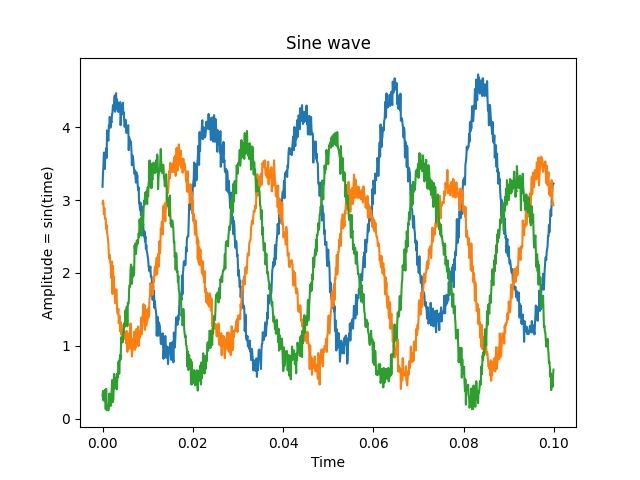

In [21]:
length_plot = int(0.1 * model.at[0, 'fs'])

fig, ax = plt.subplots()

# Sine with noise
for i in range(0, 3):

    ax.plot(model.at[i, 'time'][0:length_plot], model.at[i, 'signal_bearing'][0:length_plot])
ax.set_title('Sine wave')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude = sin(time)')

Text(0.5, 1.0, 'Motor Current Signature Analysis - Bearing Fault')

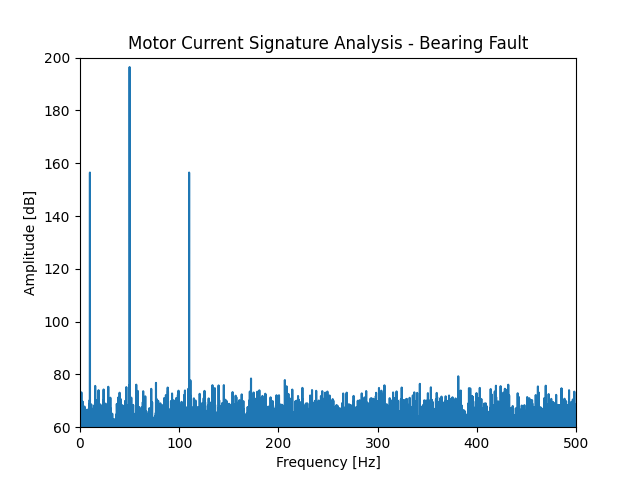

In [22]:
signal = model.at[0, 'signal_bearing']
fs = model.at[0, 'fs']

freq, fft = ESA.csa(signal, fs=fs, )
fft = DSP.decibel(fft)

fig, ax = plt.subplots()
ax.plot(freq, fft)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.set_xlim((0, 500))
ax.set_ylim((60,200))
ax.set_title(f"Motor Current Signature Analysis - Bearing Fault")